### Routine per il fine tuning del modello 

In [85]:
import netCDF4
import numpy as np
import pandas as pd
import geopandas as gpd

from datetime import datetime, timedelta
from tqdm import tqdm
from shapely.geometry import Point

from scipy.stats import skew, kurtosis, entropy

from scipy.fft import fft
from sklearn.preprocessing import MinMaxScaler

from catboost import CatBoostClassifier
from joblib import load

import os

from pycaret.classification import setup, load_model, load_experiment, compare_models, tune_model, finalize_model, save_model, plot_model, evaluate_model, dashboard, save_experiment, blend_models, get_config
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pyarrow as pa
import pyarrow.parquet as pq
from sklearn.model_selection import train_test_split


from sklearn.metrics import roc_curve
import seaborn as sns

import pandas as pd


from collections import Counter

In [86]:
ROOT_DIR = 'E:/data/RONGOWAI_L1_SDR_V1.0/'

In [87]:

class SurfaceTypeUtils:
    surface_type_dict = {
        -1: "Ocean",
        0: "NaN",
        1: "Artifical",
        2: "Barely vegetated",
        3: "Inland water",
        4: "Crop",
        5: "Grass",
        6: "Shrub",
        7: "Forest"
    }
    ddm_antennas = {
        0: 'None',
        1: 'Zenith',
        2: 'LHCP',
        3: 'RHCP',
    }

In [88]:
class NetCDFPreprocessor:
    def __init__(self, root_dir, preprocessing_method=str):
        self.root_dir = root_dir
        self.netcdf_file_list = os.listdir(root_dir)
        self.preprocessing_method = preprocessing_method
        if self.preprocessing_method not in ['filtered', 'with_lat_lons', 'unfiltered']:
            raise ValueError("Invalid preprocessing method. Choose from 'filtered', 'with_lat_lons', or 'unfiltered'.")

    @staticmethod
    def check_integrity(f):
        """Check integrity of the netCDF file"""
        if not isinstance(f, netCDF4.Dataset):
            raise ValueError("Input must be a netCDF4.Dataset object")
        if 'raw_counts' not in f.variables:
            raise KeyError("The netCDF file does not contain 'raw_counts' variable")
        if 'sp_alt' not in f.variables or 'sp_inc_angle' not in f.variables:
            raise KeyError("The netCDF file does not contain 'sp_alt' or 'sp_inc_angle' variables")
        if 'sp_rx_gain_copol' not in f.variables or 'sp_rx_gain_xpol' not in f.variables or 'ddm_snr' not in f.variables:
            raise KeyError("The netCDF file does not contain 'sp_rx_gain_copol', 'sp_rx_gain_xpol' or 'ddm_snr' variables")
        if 'sp_lat' not in f.variables or 'sp_lon' not in f.variables:
            raise KeyError("The netCDF file does not contain 'sp_lat' or 'sp_lon' variables")
        if 'sp_surface_type' not in f.variables:
            raise KeyError("The netCDF file does not contain 'sp_surface_type' variable")
        if 'ac_alt' not in f.variables:
            raise KeyError("The netCDF file does not contain 'ac_alt' variable")
        if f.variables['raw_counts'].ndim != 4:
            raise ValueError("The 'raw_counts' variable must have 4 dimensions")
        
    def preprocess(self, f):
        """ Preprocess the netCDF file and return fit data and labels """
        # Check integrity of the netCDF file
        self.check_integrity(f)
        
        # Carica i dati una volta sola, evitando np.array() non necessario
        raw_counts = f.variables['raw_counts'][:]
        
        # Ottimizzazione 1: Usa broadcasting invece di repeat
        ac_alt = f.variables['ac_alt'][:]
        sp_alt = f.variables['sp_alt'][:]
        sp_inc_angle = f.variables['sp_inc_angle'][:]
        
        # Broadcasting più efficiente (evita repeat)
        distance_2d = (ac_alt[:, np.newaxis] - sp_alt) / np.cos(np.deg2rad(sp_inc_angle))
        
        # Carica tutte le variabili necessarie
        copol = f.variables['sp_rx_gain_copol'][:]
        xpol = f.variables['sp_rx_gain_xpol'][:]
        snr = f.variables['ddm_snr'][:]
        
        
        keep_mask = (
            (copol >= 5) & 
            (xpol >= 5) & 
            (snr > 0) & 
            (distance_2d >= 2000) & 
            (distance_2d <= 10000) &
            ~np.isnan(copol) & 
            ~np.isnan(xpol) & 
            ~np.isnan(snr) & 
            ~np.isnan(distance_2d)
        )
        
        output_array = np.full(raw_counts.shape, np.nan, dtype=np.float32)
        i_indices, j_indices = np.where(keep_mask)
        output_array[i_indices, j_indices] = raw_counts[i_indices, j_indices]
        
        n_time, n_samples = raw_counts.shape[:2]
        raw_counts_reshaped = output_array.reshape(n_time * n_samples, *raw_counts.shape[2:])
        
        valid_mask = ~np.any(np.isnan(raw_counts_reshaped), axis=(1, 2)) & (np.sum(raw_counts_reshaped, axis=(1, 2)) > 0)
        
        fit_data = raw_counts_reshaped[valid_mask].reshape(valid_mask.sum(), -1)
        
        surface_types = np.nan_to_num(f.variables["sp_surface_type"][:], nan=0).ravel()
        label_data = np.isin(surface_types, np.arange(1, 8)).astype(np.int32)
        label_data = label_data[valid_mask]
        
        assert fit_data.shape[0] == len(label_data), \
            f"Shape mismatch: fit_data {fit_data.shape[0]}, label_data {len(label_data)}"
        
        return fit_data, label_data
    
    def preprocess_w_lat_lons(self, f):
        """ Version with latitude and longitude extraction """

        self.check_integrity(f)
        raw_counts = np.array(f.variables['raw_counts'])
                
        # Calcolo distanza tra il punto speculare e l'aereo
        ac_alt_2d = np.repeat(np.array(f.variables['ac_alt'])[:, np.newaxis], 20, axis=1)
        distance_2d = (ac_alt_2d - f.variables['sp_alt'][:]) / np.cos(np.deg2rad(f.variables['sp_inc_angle'][:]))

        # Seleziono gli indici dove sp_rx_gain_copol > 5, sp_rx_gain_xpol > 5 e ddm_snr > 0 e distanza tra punto speculare e antenna > 2000 e < 10000

        copol = f.variables['sp_rx_gain_copol'][:]
        xpol = f.variables['sp_rx_gain_xpol'][:]
        snr = f.variables['ddm_snr'][:]
        dist = distance_2d[:]
        specular_point_lat = f.variables['sp_lat'][:]
        specular_point_lon = f.variables['sp_lon'][:]

        # Filtraggio dei dati
        keep_mask = (copol >= 5) & (xpol >= 5) & (snr > 0) & ((dist >= 2000) & (dist <= 10000)) & (~np.isnan(copol.data) & ~np.isnan(xpol.data) & ~np.isnan(snr.data) & ~np.isnan(dist.data) & ~np.isnan(specular_point_lat.data) & ~np.isnan(specular_point_lon.data))
        to_keep_indices = np.argwhere(keep_mask)
        
        filtered_raw_counts = [raw_counts[i, j] for i, j in to_keep_indices]
        output_array = np.full(raw_counts.shape, np.nan, dtype=np.float32)

        specular_point_lats = specular_point_lat[to_keep_indices[:, 0]]
        specular_point_lons = specular_point_lon[to_keep_indices[:, 0]]
        
        for idx, (i, j) in enumerate(to_keep_indices):
            output_array[i, j] = filtered_raw_counts[idx]
                
            raw_counts_filtered = output_array.copy()

        raw_counts_filtered = output_array.copy()
        del output_array

        ddm_data_dict = {
            'Raw_Counts': raw_counts_filtered.reshape(raw_counts_filtered.shape[0]*raw_counts_filtered.shape[1], raw_counts_filtered.shape[2], raw_counts_filtered.shape[3]),
        }

        keep_indices = np.where(
            np.all(~np.isnan(ddm_data_dict['Raw_Counts']), axis=(1, 2)) & (np.sum(ddm_data_dict['Raw_Counts'], axis=(1, 2)) > 0)
        )[0]
        fit_data = np.array([ddm_data_dict['Raw_Counts'][f].ravel() for f in keep_indices])

        specular_point_lats = specular_point_lat.ravel()[keep_indices]
        specular_point_lons = specular_point_lon.ravel()[keep_indices]
        
        surface_types = f.variables["sp_surface_type"][:]
        surface_types = np.nan_to_num(surface_types, nan=0)
        surface_types_unravelled = surface_types.ravel()
        label_data = [1 if surface_type in np.arange(1, 8) else 0 for surface_type in surface_types_unravelled]
        label_data = [label_data[lab] for lab in range(len(label_data)) if lab in keep_indices]

        assert np.array(fit_data).shape[0] == len(label_data) == np.array(specular_point_lats).shape[0] == np.array(specular_point_lons).shape[0], \
            f"Shape mismatch: fit_data {np.array(fit_data).shape[0]}, label_data {len(label_data)}, lats {np.array(specular_point_lats).shape[0]}, lons {np.array(specular_point_lons).shape[0]}"
        

        return fit_data, label_data, specular_point_lats, specular_point_lons
    
    def preprocess_snr_unfiltered(self, f):
        """ Preprocess the netCDF file and return fit data and labels without filtering on signal-to-noise ratio """
        # Check integrity of the netCDF file
        self.check_integrity(f)
        
        # Carica i dati una volta sola, evitando np.array() non necessario
        raw_counts = f.variables['raw_counts'][:]
        
        # Ottimizzazione 1: Usa broadcasting invece di repeat
        ac_alt = f.variables['ac_alt'][:]
        sp_alt = f.variables['sp_alt'][:]
        sp_inc_angle = f.variables['sp_inc_angle'][:]
        
        
        distance_2d = (ac_alt[:, np.newaxis] - sp_alt) / np.cos(np.deg2rad(sp_inc_angle))
        
        # Carica tutte le variabili necessarie
        copol = f.variables['sp_rx_gain_copol'][:]
        xpol = f.variables['sp_rx_gain_xpol'][:]
        #snr = f.variables['ddm_snr'][:]
        
        
        keep_mask = (
            (copol >= 5) & 
            (xpol >= 5) & 
        #   (snr > 0) & ELiminato filtraggio su Signal-to-Noise Ratio 
            (distance_2d >= 2000) & 
            (distance_2d <= 10000) &
            ~np.isnan(copol) & 
            ~np.isnan(xpol) & 
            #~np.isnan(snr) & 
            ~np.isnan(distance_2d)
        )
        
        output_array = np.full(raw_counts.shape, np.nan, dtype=np.float32)
        i_indices, j_indices = np.where(keep_mask)
        output_array[i_indices, j_indices] = raw_counts[i_indices, j_indices]
        
        n_time, n_samples = raw_counts.shape[:2]
        raw_counts_reshaped = output_array.reshape(n_time * n_samples, *raw_counts.shape[2:])
        
        valid_mask = ~np.any(np.isnan(raw_counts_reshaped), axis=(1, 2)) & (np.sum(raw_counts_reshaped, axis=(1, 2)) > 0)
        
        fit_data = raw_counts_reshaped[valid_mask].reshape(valid_mask.sum(), -1)
        
        surface_types = np.nan_to_num(f.variables["sp_surface_type"][:], nan=0).ravel()
        label_data = np.isin(surface_types, np.arange(1, 8)).astype(np.int32)
        label_data = label_data[valid_mask]
        
        assert fit_data.shape[0] == len(label_data), \
            f"Shape mismatch: fit_data {fit_data.shape[0]}, label_data {len(label_data)}"
        
        return fit_data, label_data


    def process_all_files_random_picked(self, chunk_size = int, sample_fraction = float, n_files_to_pick= int, remove_chunks= bool):
        
        full_data = []
        full_labels = []
        counter = 0
        # Prendi 500 file random dalla lista dei file netCDF
        if int(len(self.netcdf_file_list)) > n_files_to_pick:
            np.random.seed(42)
            random_netcdf_selected_files = np.random.choice(self.netcdf_file_list, n_files_to_pick, replace=False)
            print('Selezionati 500 file netCDF casuali dalla lista')
        else:
            random_netcdf_selected_files = self.netcdf_file_list

        for file_name in tqdm(random_netcdf_selected_files, desc="Processing files"):
            if not file_name.endswith('.nc'):
                continue
            try:
                f = netCDF4.Dataset(f'{self.root_dir}{file_name}')
                if self.preprocessing_method == 'unfiltered':
                    data, labels = self.preprocess_snr_unfiltered(f)
                elif self.preprocessing_method == 'with_lat_lons':
                    data, labels, latitudes, longitudes = self.preprocess_w_lat_lons(f)
                else:
                    # Default to filtered preprocessing
                    data, labels = self.preprocess(f)
                assert (len(data) == len(labels)), f"Data and labels length mismatch in file {file_name}: {len(data)} != {len(labels)}"
                full_data.append(data)
                full_labels.append(labels)
            except Exception as e:
                print(f"Error processing file {file_name}: {e}")
                continue
            counter += 1
            if counter == n_files_to_pick:
                break  # Limita il numero di file processati per test
                
        # Trova gli indici degli elementi di full_data con seconda dimensione uguale a 200
        valid_indices = [i for i, arr in enumerate(full_data) if arr.ndim == 2 if arr.shape[1] == 200]

        # Applica la selezione a full_data e full_labels
        full_data_clean = [full_data[i] for i in valid_indices]
        full_labels_clean = [full_labels[i] for i in valid_indices]
        
        # Chunking 
        os.makedirs('test_data/binary_classification', exist_ok=True)

        chunk_size = chunk_size # dimensione del chunk in numero di campioni
        sample_fraction = sample_fraction # frazione di dati da campionare per ogni chunk

        full_data_sampled = []
        full_labels_sampled = []

        num_chunks = int(np.ceil(len(full_data_clean) / chunk_size))
        print(f"Total number of chunks: {num_chunks}")
        for idx in range(num_chunks):
            start = idx * chunk_size
            end = min((idx + 1) * chunk_size, len(full_data_clean))
            chunk_data = np.vstack(full_data_clean[start:end])
            chunk_labels = np.hstack(full_labels_clean[start:end])
            
            print(f"Chunk {idx + 1}/{num_chunks} processed with shape {chunk_data.shape} and labels shape {chunk_labels.shape}")

            # Salva ogni chunk come file parquet separato
            fit_data_df = pd.DataFrame(chunk_data)
            labels_df = pd.DataFrame(chunk_labels, columns=['label'])

            table_fit = pa.Table.from_pandas(fit_data_df, preserve_index=False)
            table_labels = pa.Table.from_pandas(labels_df, preserve_index=False)

            pq.write_table(
                table_fit,
                f'test_data/binary_classification/fit_data_chunk_{idx}.parquet',
                compression='zstd',
                use_dictionary=True,
            )
            pq.write_table(
                table_labels,
                f'test_data/binary_classification/labels_chunk_{idx}.parquet',
                compression='zstd',
                use_dictionary=True,
            )
            
        # Imposta la frazione di dati da campionare per ogni chunk (es: 0.2 per il 20%)
        
            _, X_sampled, _, y_sampled = train_test_split(
                chunk_data, chunk_labels, 
                test_size=sample_fraction, 
                stratify=chunk_labels, 
                random_state=42
            )

            
            full_data_sampled.append(X_sampled)
            full_labels_sampled.append(y_sampled)

        del full_data, full_labels

        full_data_sampled_stratified = np.vstack(full_data_sampled)
        full_labels_sampled_stratified = np.hstack(full_labels_sampled)

        del full_data_sampled, full_labels_sampled
        print(f"Shape of sampled data after chunking and sampling: {np.array(full_data_sampled_stratified).shape}")
        print(f"Shape of sampled labels after chunking and sampling: {np.array(full_labels_sampled_stratified).shape}")
        
        # Crea la cartella test_data se non esiste
        os.makedirs('test_data/binary_classification', exist_ok=True)

        # Salva fit_data in formato parquet 
        fit_data_df = pd.DataFrame(full_data_sampled_stratified)
        table_fit = pa.Table.from_pandas(fit_data_df, preserve_index=False)
        pq.write_table(
            table_fit,
            'test_data/binary_classification/fit_data_binary_test.parquet',
            compression='zstd',
            use_dictionary=True,
            
        )

        # Salva labels in formato parquet 
        labels_df = pd.DataFrame(full_labels_sampled_stratified, columns=['label'])
        table_labels = pa.Table.from_pandas(labels_df, preserve_index=False)
        pq.write_table(
            table_labels,
            'test_data/binary_classification/labels_binary_test.parquet',
            compression='zstd',
            use_dictionary=True,
            
        )
        del fit_data_df, labels_df, table_fit, table_labels
        
        print("Data and labels saved in test_data/binary_classification directory.")
        # Remove all chunk parquet files if flag is set
        if remove_chunks:
            try:
                chunk_dir = 'test_data/binary_classification'
                for fname in os.listdir(chunk_dir):
                    if fname.startswith('fit_data_chunk_') or fname.startswith('labels_chunk_'):
                        os.remove(os.path.join(chunk_dir, fname))
                print("All chunk files removed.")
            except Exception as e:
                print(f"Error removing chunk files: {e}")

        return full_data_sampled_stratified, full_labels_sampled_stratified

In [89]:
class DDMFeatureExtractor:
    def __init__(self):
        pass
    def gini(self, array):
            """Calcola il coefficiente di Gini (disuguaglianza)"""
            array = np.sort(array)
            index = np.arange(1, array.shape[0] + 1)
            return (np.sum((2 * index - array.shape[0] - 1) * array)) / (array.shape[0] * np.sum(array))    
    def extract_ddm_features(self, fit_data: np.ndarray) -> pd.DataFrame:

        """
        Estrae features dettagliate da raw_counts DDM (shape: n_samples x 200)
        """
        features = []

        for row in tqdm(fit_data, desc="Extracting DDM features"):
            f = {}
            x = np.array(row, dtype=np.float64) + 1e-10  # evita log(0)

            # 1. Statistiche base
            f['mean'] = np.mean(x)
            f['std'] = np.std(x)
            f['min'] = np.min(x)
            f['max'] = np.max(x)
            f['median'] = np.median(x)
            f['range'] = np.max(x) - np.min(x)
            f['skew'] = skew(x)
            f['kurtosis'] = kurtosis(x)
            f['entropy'] = entropy(x)
            f['gini'] = self.gini(x)

            # 2. Posizionali
            f['peak_index'] = np.argmax(x)
            f['peak_value'] = np.max(x)
            f['center_of_mass'] = np.sum(np.arange(len(x)) * x) / np.sum(x)
            f['inertia'] = np.sum(((np.arange(len(x)) - f['center_of_mass'])**2) * x)

            # 3. Segmentazione
            thirds = np.array_split(x, 3)
            for i, part in enumerate(thirds):
                f[f'sum_third_{i+1}'] = np.sum(part)
                f[f'mean_third_{i+1}'] = np.mean(part)
                f[f'max_third_{i+1}'] = np.max(part)
            
            windows = np.array_split(x, 5)
            for i, w in enumerate(windows):
                f[f'mean_w{i+1}'] = np.mean(w)
                f[f'std_w{i+1}'] = np.std(w)
                f[f'max_w{i+1}'] = np.max(w)

            # 4. Derivate e cambiamenti
            dx = np.diff(x)
            f['mean_diff'] = np.mean(dx)
            f['std_diff'] = np.std(dx)
            f['max_diff'] = np.max(dx)
            f['min_diff'] = np.min(dx)
            f['n_positive_diff'] = np.sum(dx > 0)
            f['n_negative_diff'] = np.sum(dx < 0)
            f['n_zero_diff'] = np.sum(dx == 0)

            # 5. Autocorrelazioni (lag 1-3)
            for lag in range(1, 4):
                ac = np.corrcoef(x[:-lag], x[lag:])[0, 1] if len(x) > lag else np.nan
                f[f'autocorr_lag{lag}'] = ac

            # 6. FFT (spettro frequenze)
            spectrum = np.abs(fft(x))
            half_spectrum = spectrum[:len(spectrum)//2]  # simmetrico
            f['fft_peak_freq'] = np.argmax(half_spectrum)
            f['fft_max'] = np.max(half_spectrum)
            f['fft_median'] = np.median(half_spectrum)
            f['fft_mean'] = np.mean(half_spectrum)

            
            #Aggiungi le statistiche dei quadranti e del centro
            ddm = row.reshape(10, 20)  # 10x20

            # Quadranti
            q1 = ddm[:5, :10].ravel()
            q2 = ddm[:5, 10:].ravel()
            q3 = ddm[5:, :10].ravel()
            q4 = ddm[5:, 10:].ravel()
            # Quadrante centrale (4x8 centrale)
            center = ddm[3:7, 6:14].ravel()
            
            # Statistiche dei quadranti 
            f['q1_mean'] = np.mean(q1)
            f['q2_mean'] = np.mean(q2)      
            f['q3_mean'] = np.mean(q3)
            f['q4_mean'] = np.mean(q4)
            f['center_mean'] = np.mean(center)
            f['q1_std'] = np.std(q1)
            f['q2_std'] = np.std(q2)
            f['q3_std'] = np.std(q3)
            f['q4_std'] = np.std(q4)
            f['center_std'] = np.std(center)
            f['q1_min'] = np.min(q1)
            f['q2_min'] = np.min(q2)
            f['q3_min'] = np.min(q3)
            f['q4_min'] = np.min(q4)
            f['center_min'] = np.min(center)
            f['q1_max'] = np.max(q1)
            f['q2_max'] = np.max(q2)
            f['q3_max'] = np.max(q3)
            f['q4_max'] = np.max(q4)
            f['center_max'] = np.max(center)
            f['q1_median'] = np.median(q1)
            f['q2_median'] = np.median(q2)
            f['q3_median'] = np.median(q3)
            f['q4_median'] = np.median(q4)
            f['center_median'] = np.median(center)
            f['q1_range'] = np.max(q1) - np.min(q1)
            f['q2_range'] = np.max(q2) - np.min(q2)
            f['q3_range'] = np.max(q3) - np.min(q3)
            f['q4_range'] = np.max(q4) - np.min(q4)
            f['center_range'] = np.max(center) - np.min(center)
            f['q1_skew'] = skew(q1)
            f['q2_skew'] = skew(q2)
            f['q3_skew'] = skew(q3)
            f['q4_skew'] = skew(q4)
            f['center_skew'] = skew(center)
            f['q1_kurtosis'] = kurtosis(q1)
            f['q2_kurtosis'] = kurtosis(q2)
            f['q3_kurtosis'] = kurtosis(q3)
            f['q4_kurtosis'] = kurtosis(q4)
            f['center_kurtosis'] = kurtosis(center)
            f['q1_entropy'] = entropy(q1 + 1e-10)
            f['q2_entropy'] = entropy(q2 + 1e-10)
            f['q3_entropy'] = entropy(q3 + 1e-10)
            f['q4_entropy'] = entropy(q4 + 1e-10)
            f['center_entropy'] = entropy(center + 1e-10)
            f['q1_gini'] = self.gini(q1)
            f['q2_gini'] = self.gini(q2)
            f['q3_gini'] = self.gini(q3)
            f['q4_gini'] = self.gini(q4)
            f['center_gini'] = self.gini(center)

            # Statistiche di confronto tra quadranti e centro
            
            # Differenze tra media dei quadranti e centro
            f['q1_center_mean_diff'] = f['q1_mean'] - f['center_mean']
            f['q2_center_mean_diff'] = f['q2_mean'] - f['center_mean']
            f['q3_center_mean_diff'] = f['q3_mean'] - f['center_mean']
            f['q4_center_mean_diff'] = f['q4_mean'] - f['center_mean']

            # Differenze tra std dei quadranti e centro
            f['q1_center_std_diff'] = f['q1_std'] - f['center_std']
            f['q2_center_std_diff'] = f['q2_std'] - f['center_std']
            f['q3_center_std_diff'] = f['q3_std'] - f['center_std']
            f['q4_center_std_diff'] = f['q4_std'] - f['center_std']

            # Differenze tra max dei quadranti e centro
            f['q1_center_max_diff'] = f['q1_max'] - f['center_max']
            f['q2_center_max_diff'] = f['q2_max'] - f['center_max']
            f['q3_center_max_diff'] = f['q3_max'] - f['center_max']
            f['q4_center_max_diff'] = f['q4_max'] - f['center_max']

            # Differenze tra min dei quadranti e centro
            f['q1_center_min_diff'] = f['q1_min'] - f['center_min']
            f['q2_center_min_diff'] = f['q2_min'] - f['center_min']
            f['q3_center_min_diff'] = f['q3_min'] - f['center_min']
            f['q4_center_min_diff'] = f['q4_min'] - f['center_min']

            # Differenze tra entropia dei quadranti e centro
            f['q1_center_entropy_diff'] = f['q1_entropy'] - f['center_entropy']
            f['q2_center_entropy_diff'] = f['q2_entropy'] - f['center_entropy']
            f['q3_center_entropy_diff'] = f['q3_entropy'] - f['center_entropy']
            f['q4_center_entropy_diff'] = f['q4_entropy'] - f['center_entropy']

            # Differenze tra gini dei quadranti e centro
            f['q1_center_gini_diff'] = f['q1_gini'] - f['center_gini']
            f['q2_center_gini_diff'] = f['q2_gini'] - f['center_gini']
            f['q3_center_gini_diff'] = f['q3_gini'] - f['center_gini']
            f['q4_center_gini_diff'] = f['q4_gini'] - f['center_gini']

            # Differenze tra skewness dei quadranti e centro
            f['q1_center_skew_diff'] = f['q1_skew'] - f['center_skew']
            f['q2_center_skew_diff'] = f['q2_skew'] - f['center_skew']
            f['q3_center_skew_diff'] = f['q3_skew'] - f['center_skew']
            f['q4_center_skew_diff'] = f['q4_skew'] - f['center_skew']

            # Differenze tra kurtosis dei quadranti e centro
            f['q1_center_kurtosis_diff'] = f['q1_kurtosis'] - f['center_kurtosis']
            f['q2_center_kurtosis_diff'] = f['q2_kurtosis'] - f['center_kurtosis']
            f['q3_center_kurtosis_diff'] = f['q3_kurtosis'] - f['center_kurtosis']
            f['q4_center_kurtosis_diff'] = f['q4_kurtosis'] - f['center_kurtosis']

            features.append(f)
            
        return features

### Test su 10 test_set da 50k campioni, classi distribuite uniformemente

In [90]:
read_from_backup = False
if read_from_backup:
    
    # Leggi i file parquet con polars
    fit_data_pl = pd.read_parquet('C:/Users/atogni/Desktop/rongowai/test_data/binary_classification/fit_data_binary_test.parquet')
    labels_pl = pd.read_parquet('C:/Users/atogni/Desktop/rongowai/test_data/binary_classification/labels_binary_test.parquet')

    # Trasforma in numpy array
    fit_data = fit_data_pl.to_numpy()
    labels = labels_pl['label'].to_numpy()
    del fit_data_pl, labels_pl
else:
    preprocessor = NetCDFPreprocessor(root_dir=ROOT_DIR, preprocessing_method='filtered')
    fit_data, labels = preprocessor.process_all_files_random_picked(chunk_size=250, n_files_to_pick= 1000, sample_fraction=0.9,remove_chunks=True)

Selezionati 500 file netCDF casuali dalla lista


Processing files:   0%|          | 0/1000 [00:00<?, ?it/s]

Processing files:   4%|▍         | 40/1000 [00:14<05:06,  3.14it/s]

Error processing file 20250212-195305_NZAA-NZWR_L1.nc: cannot reshape array of size 0 into shape (0,newaxis)


Processing files:  16%|█▋        | 164/1000 [00:56<03:45,  3.70it/s]

Error processing file 20240927-100501_NZHK-NZCH_L1.nc: cannot reshape array of size 0 into shape (0,newaxis)


Processing files:  31%|███       | 310/1000 [01:45<03:46,  3.05it/s]

Error processing file 20241218-201112_NZWN-NZTG_L1.nc: cannot reshape array of size 0 into shape (0,newaxis)


Processing files:  54%|█████▎    | 537/1000 [02:45<01:08,  6.73it/s]

Error processing file 20240913-073059_NZWB-NZWN_L1.nc: cannot reshape array of size 0 into shape (0,newaxis)


Processing files:  55%|█████▍    | 547/1000 [02:47<01:14,  6.11it/s]

Error processing file 20250212-174656_NZWB-NZAA_L1.nc: cannot reshape array of size 0 into shape (0,newaxis)


Processing files:  61%|██████    | 606/1000 [02:57<00:59,  6.59it/s]

Error processing file 20240926-121247_NZNV-NZCH_L1.nc: cannot reshape array of size 0 into shape (0,newaxis)


Processing files:  65%|██████▌   | 651/1000 [03:04<01:00,  5.78it/s]

Error processing file 20240912-190946_NZAA-NZWB_L1.nc: cannot reshape array of size 0 into shape (0,newaxis)


Processing files:  78%|███████▊  | 780/1000 [03:25<00:32,  6.83it/s]

Error processing file 20231107-134644_NZAA-NZKK_L1.nc: [Errno -101] NetCDF: HDF error: 'E:/data/RONGOWAI_L1_SDR_V1.0/20231107-134644_NZAA-NZKK_L1.nc'


Processing files:  91%|█████████ | 912/1000 [03:48<00:13,  6.54it/s]

Error processing file 20241219-091144_NZWN-NZNR_L1.nc: cannot reshape array of size 0 into shape (0,newaxis)


Processing files:  93%|█████████▎| 930/1000 [03:50<00:11,  6.18it/s]

Error processing file 20240913-110326_NZRO-NZWN_L1.nc: cannot reshape array of size 0 into shape (0,newaxis)


Processing files: 100%|██████████| 1000/1000 [04:02<00:00,  4.13it/s]


Total number of chunks: 4
Chunk 1/4 processed with shape (1869943, 200) and labels shape (1869943,)
Chunk 2/4 processed with shape (1901888, 200) and labels shape (1901888,)
Chunk 3/4 processed with shape (1868695, 200) and labels shape (1868695,)
Chunk 4/4 processed with shape (1918678, 200) and labels shape (1918678,)
Shape of sampled data after chunking and sampling: (6803286, 200)
Shape of sampled labels after chunking and sampling: (6803286,)
Data and labels saved in test_data/binary_classification directory.
All chunk files removed.


In [91]:
num_samples = 2000000 
indices = np.random.choice(fit_data.shape[0], size=num_samples, replace=False)
fit_data = fit_data[indices]
labels = labels[indices]

In [92]:
preprocessor = NetCDFPreprocessor(root_dir=ROOT_DIR, preprocessing_method='filtered')
features_extractor = DDMFeatureExtractor()

In [93]:
#Estrazione delle features DDM
from joblib import Parallel, delayed

def extract_ddm_features_row(row):
    return features_extractor.extract_ddm_features(np.array([row]))

combined_features = Parallel(n_jobs=12, backend="loky")(delayed(extract_ddm_features_row)(row) for row in tqdm(fit_data, desc="Estrazione features"))

Estrazione features: 100%|██████████| 2000000/2000000 [15:19<00:00, 2174.42it/s]


In [94]:
flat_features = [row[0] if isinstance(row, list) and len(row) > 0 else row for row in combined_features]
FEATURES = list(flat_features[0].keys())

combined_features = np.array([[row[key] for key in FEATURES] for row in flat_features])
combined_features.shape

# Rimuovo le righe con valori NaN o infiniti
mask_finite = np.isfinite(combined_features).all(axis=1) & (np.abs(combined_features) < np.finfo(np.float64).max).all(axis=1)
fit_data_with_features_clean = combined_features[mask_finite]
labels_clean = labels[mask_finite]

In [95]:
# cleanup memory
del labels, fit_data
del combined_features, flat_features

In [96]:
# Salvo le features e le labels in formato parquet
save = True
if save:
    # Crea la cartella processed_data/binary_classification/data_w_features se non esiste
    os.makedirs('processed_data/binary_classification/data_w_features', exist_ok=True)
    pd.DataFrame(fit_data_with_features_clean, columns=FEATURES).to_parquet('test_data/binary_classification/combined_features_filtered.parquet', index=False)
    pd.DataFrame(labels_clean).to_parquet('test_data/binary_classification/labels_binary_filtered.parquet', index=False)

In [97]:
# Crea 10 subset bilanciati di 50000 campioni ciascuno e controllo integrità e distribuzione delle classi
num_subsets = 10
subset_size = 50000

subsets_X_filtered = []
subsets_y_filtered = []

# Trova gli indici delle due classi
idx_0 = np.where(labels_clean == 0)[0]
idx_1 = np.where(labels_clean == 1)[0]
min_class_size = min(len(idx_0), len(idx_1), subset_size // 2)

for i in range(num_subsets):
    idx_0_sample = np.random.choice(idx_0, size=min_class_size, replace=False)
    idx_1_sample = np.random.choice(idx_1, size=min_class_size, replace=False)
    idx_balanced = np.concatenate([idx_0_sample, idx_1_sample])
    np.random.shuffle(idx_balanced)
    subsets_X_filtered.append(fit_data_with_features_clean[idx_balanced])
    subsets_y_filtered.append(labels_clean[idx_balanced])


# Controlla la distribuzione delle classi in ogni subset
for i, (X, y) in enumerate(zip(subsets_X_filtered, subsets_y_filtered)):
    assert len(X) == subset_size, f"Subset {i+1} size mismatch: {len(X)} != {subset_size}"
    assert len(y) == subset_size, f"Subset {i+1} labels size mismatch: {len(y)} != {subset_size}"
    print(f"Subset {i+1}: {Counter(y)}")


# Check if all elements in subsets_X_unfiltered are different
all_unique = True
for i in range(num_subsets):
    for j in range(i + 1, num_subsets):
        if np.array_equal(subsets_X_filtered[i], subsets_X_filtered[j]):
            print(f"Subset {i+1} and Subset {j+1} are identical!")
            all_unique = False
if all_unique:
    print("All subsets in subsets_X_filtered are different.")
            

Subset 1: Counter({0: 25000, 1: 25000})
Subset 2: Counter({1: 25000, 0: 25000})
Subset 3: Counter({0: 25000, 1: 25000})
Subset 4: Counter({1: 25000, 0: 25000})
Subset 5: Counter({1: 25000, 0: 25000})
Subset 6: Counter({0: 25000, 1: 25000})
Subset 7: Counter({0: 25000, 1: 25000})
Subset 8: Counter({0: 25000, 1: 25000})
Subset 9: Counter({0: 25000, 1: 25000})
Subset 10: Counter({0: 25000, 1: 25000})
All subsets in subsets_X_filtered are different.


### Caricamento modelli


In [98]:
def _load_catboost_model(model_path=str):
        """Carica il modello CatBoost dal percorso specificato"""
        try:
            model = CatBoostClassifier()
            model.load_model(str(model_path))
            #print(f"Modello caricato con successo da: {model_path}")
            return model
        except Exception as e:
            print(f"Errore nel caricamento del modello: {e}")
            raise

In [ ]:
#Catboost! 

catboost_model_path = r"./models/catboost_test120625_1946/catboost_trained_on_full_data_model_v1.cbm"
catboost_scaler_path = "./models/catboost_test120625_1946/catboost_trained_on_full_data_model_v1_scaler.joblib"
catboost_scaler = load(catboost_scaler_path)
xg_boost_model_path = "./models/xgboost/xgboost_production_model_v1.joblib"
xg_boost_scaler_path = "./models/xgboost/xgboost_production_model_v1_scaler.joblib"
xg_boost_scaler = load(xg_boost_scaler_path)

voting_classifier_path = "./models/voting_classifier/voting_classifier_v1.joblib"




models = {
    'catboost': _load_catboost_model(catboost_model_path),
    'xgboost': load(xg_boost_model_path)}


In [ ]:
#xg_boost_model_final = load_model(xg_boost_model_path)
catboost_model_final = True
xg_boost_model_final = True
voting_classifier = True



In [150]:
def check_infinite_or_large(arr, threshold=np.finfo(np.float64).max):
    """
    Restituisce True se l'array numpy contiene valori infiniti o troppo grandi per float64.
    """
    arr = np.asarray(arr)
    has_inf = np.isinf(arr).any()
    has_too_large = (np.abs(arr) >= threshold).any()
    return has_inf or has_too_large

# Esempio d'uso:
result = check_infinite_or_large(catboost_scaler.transform(subsets_X_filtered[0]))
print("Contiene infiniti o valori troppo grandi:", result)

Contiene infiniti o valori troppo grandi: False


In [161]:

# Preprocessing for xg_boost_model_final (dict with scaler and label_encoder)
from pyexpat import model


def preprocess_for_xgboost(X):
    return xg_boost_scaler.transform(X)

def predict_with_xgboost(X):
    X_proc = preprocess_for_xgboost(X)
    model = load(xg_boost_model_path)
    return model.predict(X_proc)

def preprocess_for_catboost(X):
        return catboost_scaler.transform(X)
    
def predict_with_catboost(X):
    X_proc = preprocess_for_catboost(X)
    model = _load_catboost_model(catboost_model_path)
    return model.predict(X_proc)

# Preprocessing for pycaret pipeline models
def preprocess_for_pycaret(model, X):
    # Applica MinMaxScaler se presente nella pipeline del modello pycaret
    scaler = None
    for name, step in model.named_steps.items():
        if "minmax" in name or "min_max" in name:
            scaler = step
            break
    if scaler is not None:
        X = scaler.transform(X)
    return X
    #X = model.transform(X)
    #feature_names = [f"features_{i+1}" for i in range(len(FEATURES))]
    #return pd.DataFrame(X)
    pass
    
def predict_with_pycaret(model, X):
    #X_proc = preprocess_for_pycaret(model, X)
    return model.predict(X)

# Preprocessing for sklearn models (e.g., RandomForest)
def preprocess_for_sklearn(X):
    # Assume features are already in correct format
    return X

def predict_with_sklearn(model, X):
    X_proc = preprocess_for_sklearn(X)
    return model.predict(X_proc)


### Test on filtered test data


=== xgboost ===
Subset 1: Accuracy = 0.8497
Confusion Matrix:
[[20378  4622]
 [ 2891 22109]]
Subset 2: Accuracy = 0.8508
Confusion Matrix:
[[20367  4633]
 [ 2825 22175]]
Subset 3: Accuracy = 0.8524
Confusion Matrix:
[[20420  4580]
 [ 2799 22201]]
Subset 4: Accuracy = 0.8501
Confusion Matrix:
[[20427  4573]
 [ 2924 22076]]
Subset 5: Accuracy = 0.8522
Confusion Matrix:
[[20392  4608]
 [ 2781 22219]]
Subset 6: Accuracy = 0.8511
Confusion Matrix:
[[20392  4608]
 [ 2836 22164]]
Subset 7: Accuracy = 0.8528
Confusion Matrix:
[[20442  4558]
 [ 2801 22199]]
Subset 8: Accuracy = 0.8528
Confusion Matrix:
[[20458  4542]
 [ 2817 22183]]
Subset 9: Accuracy = 0.8508
Confusion Matrix:
[[20451  4549]
 [ 2909 22091]]
Subset 10: Accuracy = 0.8505
Confusion Matrix:
[[20414  4586]
 [ 2890 22110]]
Mean Accuracy: 0.8513
Std Accuracy: 0.0011

Media accuratezze: 0.8513 ± 0.0011
Confusion Matrix media:
[[20414  4585]
 [ 2847 22152]]


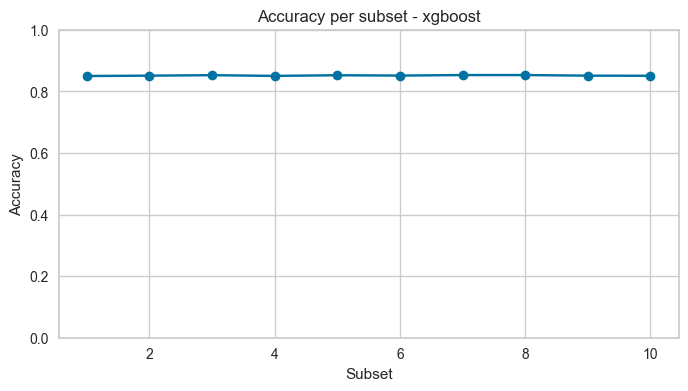

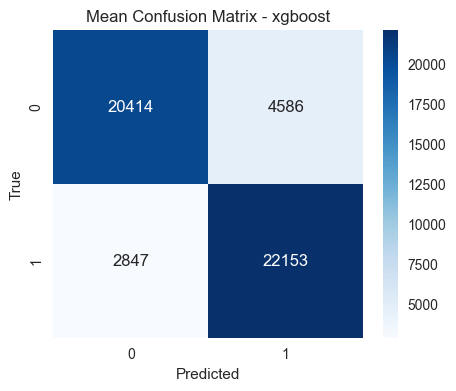

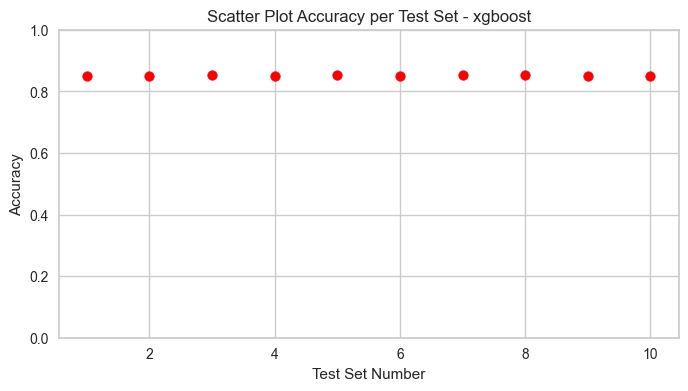


=== catboost ===
Subset 1: Accuracy = 0.8482
Confusion Matrix:
[[20345  4655]
 [ 2936 22064]]
Subset 2: Accuracy = 0.8489
Confusion Matrix:
[[20320  4680]
 [ 2877 22123]]
Subset 3: Accuracy = 0.8502
Confusion Matrix:
[[20368  4632]
 [ 2858 22142]]
Subset 4: Accuracy = 0.8488
Confusion Matrix:
[[20420  4580]
 [ 2980 22020]]
Subset 5: Accuracy = 0.8507
Confusion Matrix:
[[20381  4619]
 [ 2847 22153]]
Subset 6: Accuracy = 0.8498
Confusion Matrix:
[[20359  4641]
 [ 2867 22133]]
Subset 7: Accuracy = 0.8511
Confusion Matrix:
[[20409  4591]
 [ 2853 22147]]
Subset 8: Accuracy = 0.8509
Confusion Matrix:
[[20423  4577]
 [ 2878 22122]]
Subset 9: Accuracy = 0.8501
Confusion Matrix:
[[20443  4557]
 [ 2939 22061]]
Subset 10: Accuracy = 0.8485
Confusion Matrix:
[[20359  4641]
 [ 2932 22068]]
Mean Accuracy: 0.8497
Std Accuracy: 0.0010

Media accuratezze: 0.8497 ± 0.0010
Confusion Matrix media:
[[20382  4617]
 [ 2896 22103]]


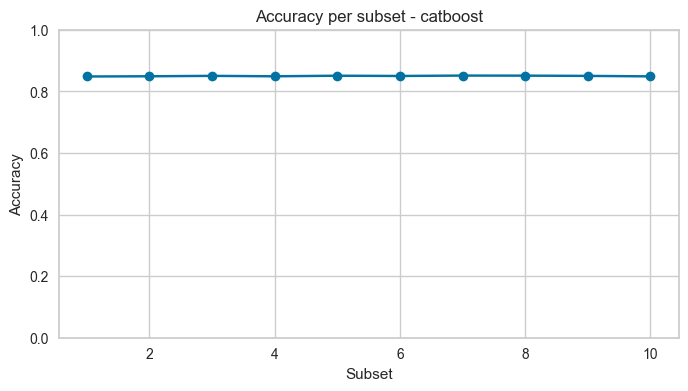

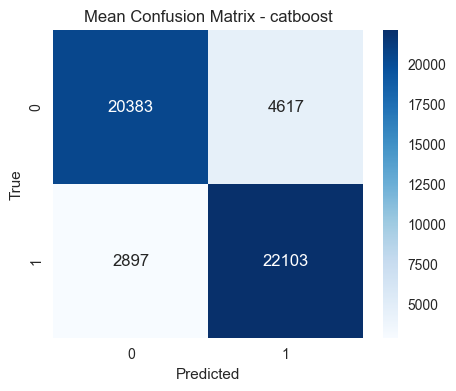

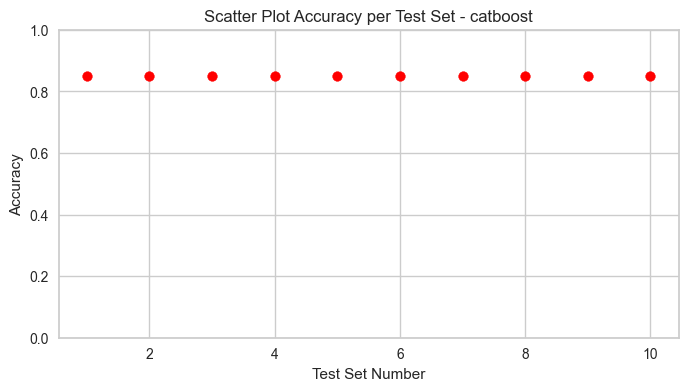

In [ ]:

# Build models dict with wrappers for preprocessing
from numpy import void


models = {}

if xg_boost_model_final is not None:
    models["xgboost"] = type(
        "XGBWrapper", (), {"predict": staticmethod(predict_with_xgboost)}
    )()

if best_binary_classification_model is not None:
    models["Best Binary Classification Model"] = type(
        "PyCaretWrapper", (), {"predict": staticmethod(lambda X: predict_with_pycaret(best_binary_classification_model, X))}
    )()

if best_random_forest_model is not None:
    models["Best Random Forest Model"] = type(
        "RFWrapper", (), {"predict": staticmethod(lambda X: predict_with_sklearn(best_random_forest_model, X))}
    )()

if best_binary_classification_ensembled_model is not None:
    models["Best Binary Classification Ensembled Model"] = type(
        "PyCaretEnsembleWrapper", (), {"predict": staticmethod(lambda X: predict_with_pycaret(best_binary_classification_ensembled_model, X))}
    )()

if catboost_model_final is not None:
    models["catboost"] = type(
        "CatBoostWrapper", (), {"predict": staticmethod(predict_with_catboost)}
    )()
    
if voting_classifier is not None:
    models["Voting Classifier"] = type(
        "VotingClassifierWrapper", (), {"predict": staticmethod(lambda X: voting_classifier.predict(X))}
    )()

for model_name, model in models.items():
    print(f"\n=== {model_name} ===")
    accs = []
    cms = []
    for i in range(num_subsets):
        X = subsets_X_filtered[i]
        y = subsets_y_filtered[i]
        
        # Ricerca della soglia ottimale per la classificazione binaria (solo se il modello supporta predict_proba)
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X)[:, 1]
            fpr, tpr, thresholds = roc_curve(y, y_proba)
            # Soglia ottimale: massimizza tpr - fpr (Youden's J statistic)
            optimal_idx = np.argmax(tpr - fpr)
            optimal_threshold = thresholds[optimal_idx]
            print(f"SOGLIA OTTIMALE DI CLASSIFICAZIONE: {optimal_threshold:.4f}")
            y_pred = (y_proba >= optimal_threshold).astype(int)
        else:
            y_pred = model.predict(X)

        
        acc = accuracy_score(y, y_pred)
        cm = confusion_matrix(y, y_pred)
        print(f"Subset {i+1}: Accuracy = {acc:.4f}")
        print(f"Confusion Matrix:\n{cm}")
        accs.append(acc)
        cms.append(cm)
    print(f"Mean Accuracy: {np.mean(accs):.4f}")
    print(f"Std Accuracy: {np.std(accs):.4f}")
    
    # Media delle accuratezze e confusion matrix media
    mean_acc = np.mean(accs)
    std_acc = np.std(accs)
    mean_cm = np.mean(np.array(cms), axis=0)
    print(f"\nMedia accuratezze: {mean_acc:.4f} ± {std_acc:.4f}")
    print(f"Confusion Matrix media:\n{mean_cm.astype(int)}")
    import matplotlib.pyplot as plt

    # Plot accuracy per subset
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, num_subsets + 1), accs, marker='o')
    plt.title(f'Accuracy per subset - {model_name}')
    plt.xlabel('Subset')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.show()

    # Plot mean confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(mean_cm, annot=True, fmt='.0f', cmap='Blues')
    plt.title(f'Mean Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    # Calcola il classification report medio su tutti i subset

    reports = []
    for i in range(num_subsets):
        y_true = subsets_y_filtered[i]
        y_pred = model.predict(subsets_X_filtered[i])
        report = classification_report(y_true, y_pred, output_dict=True)
        reports.append(report)
        
    # Scatter plot delle accuratezze in funzione del numero del test set
    plt.figure(figsize=(8, 4))
    plt.scatter(range(1, num_subsets + 1), accs, color='red')
    plt.title(f'Scatter Plot Accuracy per Test Set - {model_name}')
    plt.xlabel('Test Set Number')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.show()

    

### Test su dati non filtrati


In [71]:
read_from_backup = False
if read_from_backup:
    
    # Leggi i file parquet con polars
    fit_data_pl = pd.read_parquet('C:/Users/atogni/Desktop/rongowai/test_data/binary_classification/fit_data_binary_test.parquet')
    labels_pl = pd.read_parquet('C:/Users/atogni/Desktop/rongowai/test_data/binary_classification/labels_binary_test.parquet')

    # Trasforma in numpy array
    fit_data = fit_data_pl.to_numpy()
    labels = labels_pl['label'].to_numpy()
    del fit_data_pl, labels_pl
else:
    preprocessor = NetCDFPreprocessor(root_dir=ROOT_DIR, preprocessing_method='unfiltered')
    fit_data, labels = preprocessor.process_all_files_random_picked(chunk_size=250, n_files_to_pick=1000, sample_fraction=0.9,remove_chunks=True)
    

num_samples = 2000000 
indices = np.random.choice(fit_data.shape[0], size=num_samples, replace=False)
fit_data = fit_data[indices]
labels = labels[indices]

Selezionati 500 file netCDF casuali dalla lista


Processing files:   4%|▍         | 40/1000 [00:04<01:41,  9.48it/s]

Error processing file 20250212-195305_NZAA-NZWR_L1.nc: cannot reshape array of size 0 into shape (0,newaxis)


Processing files:  16%|█▋        | 163/1000 [00:19<01:33,  8.95it/s]

Error processing file 20240927-100501_NZHK-NZCH_L1.nc: cannot reshape array of size 0 into shape (0,newaxis)


Processing files:  31%|███       | 311/1000 [00:38<01:28,  7.82it/s]

Error processing file 20241218-201112_NZWN-NZTG_L1.nc: cannot reshape array of size 0 into shape (0,newaxis)


Processing files:  54%|█████▎    | 537/1000 [01:05<00:52,  8.84it/s]

Error processing file 20240913-073059_NZWB-NZWN_L1.nc: cannot reshape array of size 0 into shape (0,newaxis)


Processing files:  55%|█████▍    | 548/1000 [01:06<00:56,  8.00it/s]

Error processing file 20250212-174656_NZWB-NZAA_L1.nc: cannot reshape array of size 0 into shape (0,newaxis)


Processing files:  60%|██████    | 605/1000 [01:13<00:40,  9.82it/s]

Error processing file 20240926-121247_NZNV-NZCH_L1.nc: cannot reshape array of size 0 into shape (0,newaxis)


Processing files:  65%|██████▌   | 652/1000 [01:19<00:50,  6.88it/s]

Error processing file 20240912-190946_NZAA-NZWB_L1.nc: cannot reshape array of size 0 into shape (0,newaxis)


Processing files:  78%|███████▊  | 780/1000 [01:35<00:25,  8.64it/s]

Error processing file 20231107-134644_NZAA-NZKK_L1.nc: [Errno -101] NetCDF: HDF error: 'E:/data/RONGOWAI_L1_SDR_V1.0/20231107-134644_NZAA-NZKK_L1.nc'


Processing files:  91%|█████████▏| 913/1000 [01:51<00:09,  9.58it/s]

Error processing file 20241219-091144_NZWN-NZNR_L1.nc: cannot reshape array of size 0 into shape (0,newaxis)


Processing files:  93%|█████████▎| 930/1000 [01:53<00:08,  8.14it/s]

Error processing file 20240913-110326_NZRO-NZWN_L1.nc: cannot reshape array of size 0 into shape (0,newaxis)


Processing files: 100%|██████████| 1000/1000 [02:01<00:00,  8.20it/s]


Total number of chunks: 4
Chunk 1/4 processed with shape (6280148, 200) and labels shape (6280148,)
Chunk 2/4 processed with shape (6267190, 200) and labels shape (6267190,)
Chunk 3/4 processed with shape (6221175, 200) and labels shape (6221175,)
Chunk 4/4 processed with shape (6057781, 200) and labels shape (6057781,)
Shape of sampled data after chunking and sampling: (22343666, 200)
Shape of sampled labels after chunking and sampling: (22343666,)
Data and labels saved in test_data/binary_classification directory.
All chunk files removed.


In [72]:
preprocessor = NetCDFPreprocessor(root_dir=ROOT_DIR, preprocessing_method='unfiltered')
features_extractor = DDMFeatureExtractor()

In [73]:
#Estrazione delle features DDM
from joblib import Parallel, delayed

def extract_ddm_features_row(row):
    return features_extractor.extract_ddm_features(np.array([row]))

combined_features_unfiltered = Parallel(n_jobs=12, backend="loky")(delayed(extract_ddm_features_row)(row) for row in tqdm(fit_data, desc="Estrazione features"))

Estrazione features: 100%|██████████| 2000000/2000000 [15:56<00:00, 2091.00it/s]


In [74]:
flat_features_unfiltered = [row[0] if isinstance(row, list) and len(row) > 0 else row for row in combined_features_unfiltered]
FEATURES = list(flat_features_unfiltered[0].keys())

combined_features_unfiltered = np.array([[row[key] for key in FEATURES] for row in flat_features_unfiltered])
combined_features_unfiltered.shape

# Rimuovo le righe con valori NaN o infiniti
mask_finite = np.isfinite(combined_features_unfiltered).all(axis=1) & (np.abs(combined_features_unfiltered) < np.finfo(np.float64).max).all(axis=1)
fit_data_with_features_unfiltered_clean = combined_features_unfiltered[mask_finite]
labels_unfiltered_clean = labels[mask_finite]

In [75]:
# cleanup memory
del labels, fit_data
del combined_features_unfiltered, flat_features_unfiltered

In [76]:
# Salvo le features e le labels in formato parquet
save = True
if save:
    # Crea la cartella processed_data/binary_classification/data_w_features se non esiste
    os.makedirs('processed_data/binary_classification/data_w_features', exist_ok=True)
    pd.DataFrame(fit_data_with_features_unfiltered_clean, columns=FEATURES).to_parquet('test_data/binary_classification/combined_features_binary_snr_unfiltered.parquet', index=False)
    pd.DataFrame(labels_unfiltered_clean).to_parquet('test_data/binary_classification/labels_binary_snr_unfiltered.parquet', index=False)

In [ ]:
# Crea 10 subset bilanciati di 50000 campioni ciascuno e controllo integrità e distribuzione delle classi
num_subsets = 10
subset_size = 50000

subsets_X_unfiltered = []
subsets_y_unfiltered = []

# Trova gli indici delle due classi
idx_0 = np.where(labels_clean == 0)[0]
idx_1 = np.where(labels_clean == 1)[0]
min_class_size = min(len(idx_0), len(idx_1), subset_size // 2)

for i in range(num_subsets):
    idx_0_sample = np.random.choice(idx_0, size=min_class_size, replace=False)
    idx_1_sample = np.random.choice(idx_1, size=min_class_size, replace=False)
    idx_balanced = np.concatenate([idx_0_sample, idx_1_sample])
    np.random.shuffle(idx_balanced)
    subsets_X_unfiltered.append(fit_data_with_features_clean[idx_balanced])
    subsets_y_unfiltered.append(labels_clean[idx_balanced])


# Controlla la distribuzione delle classi in ogni subset
for i, (X, y) in enumerate(zip(subsets_X_unfiltered, subsets_y_unfiltered)):
    assert len(X) == subset_size, f"Subset {i+1} size mismatch: {len(X)} != {subset_size}"
    assert len(y) == subset_size, f"Subset {i+1} labels size mismatch: {len(y)} != {subset_size}"
    print(f"Subset {i+1}: {Counter(y)}")


# Check if all elements in subsets_X_unfiltered are different
all_unique = True
for i in range(num_subsets):
    for j in range(i + 1, num_subsets):
        if np.array_equal(subsets_X_unfiltered[i], subsets_X_unfiltered[j]):
            print(f"Subset {i+1} and Subset {j+1} are identical!")
            all_unique = False
if all_unique:
    print("All subsets in subsets_X_unfiltered are different.")

Subset 1: Counter({1: 25000, 0: 25000})
Subset 2: Counter({1: 25000, 0: 25000})
Subset 3: Counter({1: 25000, 0: 25000})
Subset 4: Counter({1: 25000, 0: 25000})
Subset 5: Counter({1: 25000, 0: 25000})
Subset 6: Counter({0: 25000, 1: 25000})
Subset 7: Counter({0: 25000, 1: 25000})
Subset 8: Counter({1: 25000, 0: 25000})
Subset 9: Counter({1: 25000, 0: 25000})
Subset 10: Counter({1: 25000, 0: 25000})



=== CatBoost Model Final ===
Subset 1: Accuracy = 0.8488
Confusion Matrix:
[[20353  4647]
 [ 2913 22087]]
Subset 2: Accuracy = 0.8508
Confusion Matrix:
[[20464  4536]
 [ 2922 22078]]
Subset 3: Accuracy = 0.8484
Confusion Matrix:
[[20369  4631]
 [ 2949 22051]]
Subset 4: Accuracy = 0.8476
Confusion Matrix:
[[20334  4666]
 [ 2955 22045]]
Subset 5: Accuracy = 0.8494
Confusion Matrix:
[[20351  4649]
 [ 2881 22119]]
Subset 6: Accuracy = 0.8471
Confusion Matrix:
[[20390  4610]
 [ 3034 21966]]
Subset 7: Accuracy = 0.8512
Confusion Matrix:
[[20471  4529]
 [ 2912 22088]]
Subset 8: Accuracy = 0.8488
Confusion Matrix:
[[20402  4598]
 [ 2963 22037]]
Subset 9: Accuracy = 0.8527
Confusion Matrix:
[[20422  4578]
 [ 2787 22213]]
Subset 10: Accuracy = 0.8490
Confusion Matrix:
[[20332  4668]
 [ 2880 22120]]
Mean Accuracy: 0.8494
Std Accuracy: 0.0016

Media accuratezze: 0.8494 ± 0.0016
Confusion Matrix media:
[[20388  4611]
 [ 2919 22080]]


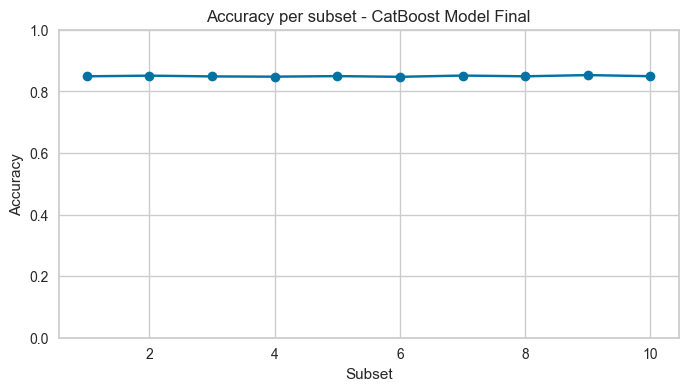

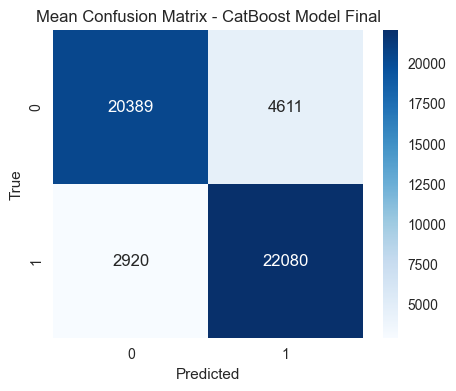

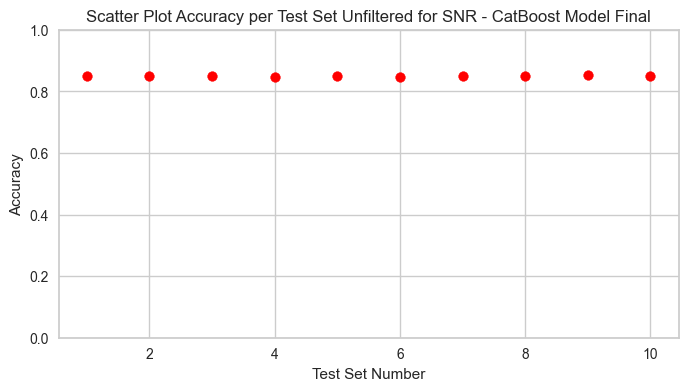

In [84]:
# Build models dict with wrappers for preprocessing
models = {}

if xg_boost_model_final is not None:
    models["XGBoost Model Final"] = type(
        "XGBWrapper", (), {"predict": staticmethod(predict_with_xgboost)}
    )()

if best_binary_classification_model is not None:
    models["Best Binary Classification Model"] = type(
        "PyCaretWrapper", (), {"predict": staticmethod(lambda X: predict_with_pycaret(best_binary_classification_model, X))}
    )()

if best_random_forest_model is not None:
    models["Best Random Forest Model"] = type(
        "RFWrapper", (), {"predict": staticmethod(lambda X: predict_with_sklearn(best_random_forest_model, X))}
    )()

if best_binary_classification_ensembled_model is not None:
    models["Best Binary Classification Ensembled Model"] = type(
        "PyCaretEnsembleWrapper", (), {"predict": staticmethod(lambda X: predict_with_pycaret(best_binary_classification_ensembled_model, X))}
    )()
if catboost_model_final is not None:
    models["CatBoost Model Final"] = type(
        "CatBoostWrapper", (), {"predict": staticmethod(predict_with_catboost)}
    )()

for model_name, model in models.items():
    print(f"\n=== {model_name} ===")
    accs = []
    cms = []
    for i in range(num_subsets):
        X = subsets_X_unfiltered[i]
        y = subsets_y_unfiltered[i]
        
        # Ricerca della soglia ottimale per la classificazione binaria (solo se il modello supporta predict_proba)
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X)[:, 1]
            fpr, tpr, thresholds = roc_curve(y, y_proba)
            # Soglia ottimale: massimizza tpr - fpr (Youden's J statistic)
            optimal_idx = np.argmax(tpr - fpr)
            optimal_threshold = thresholds[optimal_idx]
            print(f"SOGLIA OTTIMALE DI CLASSIFICAZIONE: {optimal_threshold:.4f}")
            y_pred = (y_proba >= optimal_threshold).astype(int)
        else:
            y_pred = model.predict(X)

        
        acc = accuracy_score(y, y_pred)
        cm = confusion_matrix(y, y_pred)
        print(f"Subset {i+1}: Accuracy = {acc:.4f}")
        print(f"Confusion Matrix:\n{cm}")
        accs.append(acc)
        cms.append(cm)
    print(f"Mean Accuracy: {np.mean(accs):.4f}")
    print(f"Std Accuracy: {np.std(accs):.4f}")
    
    # Media delle accuratezze e confusion matrix media
    mean_acc = np.mean(accs)
    std_acc = np.std(accs)
    mean_cm = np.mean(np.array(cms), axis=0)
    print(f"\nMedia accuratezze: {mean_acc:.4f} ± {std_acc:.4f}")
    print(f"Confusion Matrix media:\n{mean_cm.astype(int)}")
    import matplotlib.pyplot as plt

    # Plot accuracy per subset
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, num_subsets + 1), accs, marker='o')
    plt.title(f'Accuracy per subset - {model_name}')
    plt.xlabel('Subset')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.show()

    # Plot mean confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(mean_cm, annot=True, fmt='.0f', cmap='Blues')
    plt.title(f'Mean Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    # Calcola il classification report medio su tutti i subset

    reports = []
    for i in range(num_subsets):
        y_true = subsets_y_unfiltered[i]
        y_pred = model.predict(subsets_X_unfiltered[i])
        report = classification_report(y_true, y_pred, output_dict=True)
        reports.append(report)
        
    # Scatter plot delle accuratezze in funzione del numero del test set
    plt.figure(figsize=(8, 4))
    plt.scatter(range(1, num_subsets + 1), accs, color='red')
    plt.title(f'Scatter Plot Accuracy per Test Set Unfiltered for SNR - {model_name}')
    plt.xlabel('Test Set Number')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.show()